First, generate a random model

In [1]:
import numpy as np
import pylab as plt
from bioscrape.simulator import *
from bioscrape.types import *
import warnings


#Parameter ranges to randomly choose parameters (on a log scale)
param_min = -2
param_max = 2

#Names of different supported propensities
propensity_types = ['massaction', 'hillpositive', 'proportionalhillpositive', 'hillnegative', 'proportionalhillnegative', 'massaction']#, 'general']

#parameter names required for each propensity (general will be treated by itself)
propensity_param_requirements = {
	'massaction':['k'], 'hillpositive':['k', 'K', 'n'], 'hillnegative':['k', 'K', 'n'],
	'proportionalhillpositive':["k", "K", "n"], 'proportionalhillnegative':["k", "K", "n"]
}
#species (passed in as parameters) requires for each propensity (general will be treated by itself)
propensity_specie_requirements = {
	'hillpositive':['s1'], 'hillnegative':['s1'], 'proportionalhillpositive':['s1', 'd'], 'proportionalhillnegative':['s1', 'd'], "massaction":[]
}


species = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
n_species = len(species)
n_reactions = np.random.randint(1, 3)

reactions = []
for r in range(n_reactions):

    try_again = True
    while try_again:#Loop ensures no positive feedback which leads to long simulations
        inputs = []
        outputs = []
        while(len(inputs) == 0 and len(outputs) == 0):

            n_inputs = np.random.randint(0, 5)
            for i in range(n_inputs):
                inputs.append(species[np.random.randint(0, len(species))])

            n_outputs = np.random.randint(0, 5)
            for i in range(n_outputs):
                outputs.append(species[np.random.randint(0, len(species))])

        inputs_in_outputs = len([i for i in inputs if i in outputs])
        if inputs_in_outputs >= len(inputs):
            try_again = True
        else:
            try_again = False

    prop_type = propensity_types[np.random.randint(0, len(propensity_types))]
    param_dict = {}
    if prop_type != 'general':
        required_params = propensity_param_requirements[prop_type]
        required_species = propensity_specie_requirements[prop_type]
        param_dict = {}
        for p in required_params:
            param_dict[p] = round(np.exp(np.random.uniform(low = param_min, high = param_max)), 3)
        for i in range(len(required_species)):
            k = required_species[i]
            param_dict[k] = species[np.random.randint(0, len(species))]

    elif prop_type == 'general': #Here we will use a random(ish) rational function
        rate_str = "(1+"
        numerator_terms = np.random.randint(0, 5)
        denominator_terms = np.random.randint(0, 5)
        for i in range(numerator_terms):
            coef = str(round(np.exp(np.random.uniform(low = param_min, high = param_max)), 3))
            exp = str(round(np.random.uniform(low = 0, high = param_max), 3))
            specie = species[np.random.randint(0, len(species))]
            rate_str += coef+"*"+specie+"^"+exp+"+"
        rate_str =  rate_str[:-1] + ")"
        rate_str += "/(1+"
        for i in range(denominator_terms):
            coef =str(round(np.exp(np.random.uniform(low = param_min, high = param_max)), 3))
            exp = str(round(np.random.uniform(low = 0, high = param_max), 3))
            specie = species[np.random.randint(0, len(species))]
            rate_str += coef+"*"+specie+"^"+exp+"+"
        rate_str =  rate_str[:-1] + ")"
        param_dict['rate'] = rate_str

    rxn = (inputs, outputs, prop_type, param_dict)
    reactions.append(rxn)


print("Bioscrape model #rxns=", len(reactions), "\nrxns=", reactions)
M = Model(reactions = reactions, initial_condition_dict = {s:np.random.randint(10, 100) for s in species})
M.write_bioscrape_xml('models/random_model.xml')
M2 = Model('models/random_model.xml')
print("Loaded Model \n", M2.get_reactions())

Bioscrape model #rxns= 2 
rxns= [(['E', 'F'], ['B'], 'massaction', {'k': 0.968}), (['F', 'C'], ['E', 'G'], 'proportionalhillpositive', {'k': 6.866, 'K': 6.008, 'n': 0.155, 's1': 'D', 'd': 'A'})]
Loaded Model 
 [(<bioscrape.types.BimolecularPropensity object at 0x00000201F2DD5390>, <bioscrape.types.NoDelay object at 0x00000201F2D49C90>, {'E': -1, 'F': -1, 'B': 1}, {}), (<bioscrape.types.PositiveProportionalHillPropensity object at 0x00000201F2DE3180>, <bioscrape.types.NoDelay object at 0x00000201F2D49C70>, {'F': -1, 'C': -1, 'E': 1, 'G': 1}, {})]


first simulation successful
second simulation successful


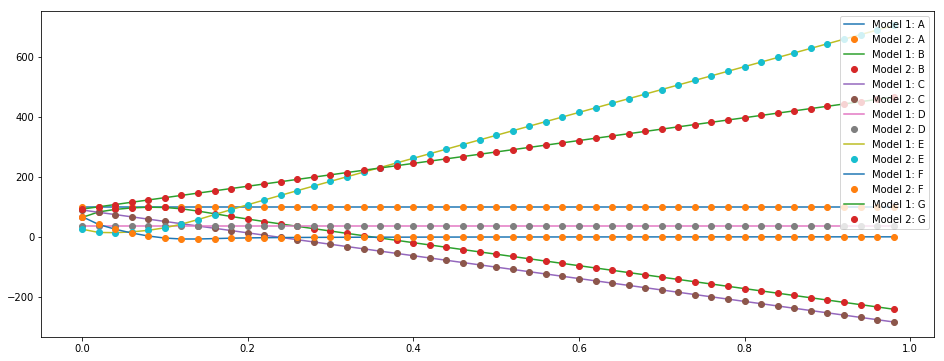

In [2]:
timepoints = np.arange(0, 1., .02)
results_1 = py_simulate_model(timepoints, Model = M, stochastic = False, safe = False)
print("first simulation successful")

results_2 = py_simulate_model(timepoints, Model = M2, stochastic = False, safe = False)
print("second simulation successful")

plt.figure(figsize = (16, 6))
for s in species:
    plt.plot(timepoints, results_1[s], "-", label = "Model 1: "+s)
    plt.plot(timepoints, results_2[s], "o", label = "Model 2: "+s)
plt.legend()
plt.show()
    